<a href="https://colab.research.google.com/github/buikhanhhung/Learning-hash-for-image-retrieval/blob/main/Copy_of_Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
########################## KẾT NỐI VỚI DRIVE ###################################
# LƯU Ý: KHI ĐÃ CÓ TRỌNG SỐ THÌ PHẢI CHẠY TRÊN RUNTIME CPU

# Nhập module drive từ thư viện google.colab để làm việc với Google Drive
# Gắn (mount) Google Drive vào thư mục '/content/drive' để có thể truy cập tệp tin trên Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
########################## VIẾT HÀM TÍNH MAP ##################333333333333333

# Nhập thư viện torch để xử lý tensor và thực hiện các phép toán
import torch

# Hàm này để tính chỉ số mAP
def compute_map_score(train_hash_codes, train_ground_truths, query_hash_codes, query_ground_truths):
    """
    Hàm tính toán chỉ số mAP (mean Average Precision) giữa tập truy vấn và tập huấn luyện
    (trong ngữ cảnh truy xuất ảnh dựa vào mã hash nhị phân).

    :param train_hash_codes: Tensor có kích thước (num_train, hash_length), chứa mã hash nhị phân của ảnh huấn luyện
    :param train_ground_truths: Tensor kích thước (num_train,), chứa nhãn (label) tương ứng với ảnh huấn luyện
    :param query_hash_codes: Tensor kích thước (num_query, hash_length), chứa mã hash nhị phân của ảnh truy vấn
    :param query_ground_truths: Tensor kích thước (num_query,), chứa nhãn của ảnh truy vấn
    :return: map_score: Giá trị trung bình của Average Precision qua tất cả các truy vấn
    """

    AP = []  # Danh sách lưu Average Precision (AP) của từng truy vấn
    num_samples = torch.arange(1, train_hash_codes.size(0) + 1)  # [1, 2, ..., num_train]

    # Duyệt từng truy vấn
    for i in range(query_hash_codes.size(0)):
        query_label = query_ground_truths[i]       # Nhãn của truy vấn
        query_hash = query_hash_codes[i]           # Mã hash nhị phân của truy vấn

        # Tính khoảng cách Hamming giữa truy vấn và tất cả ảnh trong tập huấn luyện
        hamming_dist = torch.sum((query_hash != train_hash_codes).long(), dim=1)

        # Sắp xếp theo thứ tự tăng dần của khoảng cách Hamming (ảnh gần trước, xa sau)
        ranking = hamming_dist.argsort()

        # Xác định các ảnh huấn luyện có cùng nhãn với truy vấn (đúng)
        correct = (query_label == train_ground_truths[ranking]).float().to('cpu')

        # Tính vector độ chính xác tại từng vị trí (precision@k)
        P = torch.cumsum(correct, dim=0) / num_samples

        # Tính AP = trung bình độ chính xác tại các vị trí đúng
        AP.append(torch.sum(P * correct) / torch.sum(correct))

    # Trung bình AP trên tất cả các truy vấn → mAP
    map_score = torch.mean(torch.Tensor(AP))
    return map_score



In [ ]:
############################ TẢI THƯ VIÊN CÂN THIẾT ##############################

!pip install pip==23.2.1
!pip install pytorch-lightning==1.5.10
!pip uninstall -y faiss-gpu faiss
!pip install faiss-cpu


DEPRECATION: pytorch-lightning 1.5.10 has a non-standard dependency specifier torch>=1.7.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pytorch-lightning 1.5.10 has a non-standard dependency specifier torch>=1.7.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Obtaining dependency information for faiss-cpu from https://files.pythonhosted.org/packages/53/45/7c85551025d9f0237d891b5cffdc5d4a366011d53b4b0a423b972cc52cea/faiss_cpu-1.11.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata
  Using

In [ ]:
######################### IMPORT CÁC THU VIỆN CẦN THIẾT #######################

import argparse
from itertools import combinations_with_replacement
from pathlib import Path
from typing import Any
from PIL import Image
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from torch.linalg import vector_norm
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets.cifar import CIFAR10
import faiss
import matplotlib.pyplot as plt


In [ ]:

################################### MÔ HÌNH DEEP SUPERVISED HASHING #################################

# Định nghĩa mô hình Deep Supervised Hashing (DSH)
class Classifier(pl.LightningModule):
    def __init__(self, hash_length=48, learning_rate=0.0001, weight_decay=0.004, regularization_weight_alpha=0.01):
        super().__init__()
        self.save_hyperparameters()
        # Các lớp Convolutional
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5, 5), padding='same')
        self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(5, 5), padding='same')
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5), padding='same')
        # Các lớp Fully Connected
        self.fc1 = torch.nn.Linear(in_features=3 * 3 * 64, out_features=500)
        self.fc2 = torch.nn.Linear(in_features=500, out_features=self.hparams.hash_length)
        # Khởi tạo trọng số bằng Xavier
        for layer in [self.conv1, self.conv2, self.conv3, self.fc1, self.fc2]:
            torch.nn.init.xavier_uniform_(layer.weight)
        # Max Pooling
        self.maxPool = torch.nn.MaxPool2d(kernel_size=(3, 3), stride=2)

     # Lan truyền tiến
    def forward(self, x):
        x = torch.relu(self.maxPool(self.conv1(x)))
        x = torch.relu(self.maxPool(self.conv2(x)))
        x = torch.relu(self.maxPool(self.conv3(x)))
        x = torch.flatten(x, start_dim=1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    @staticmethod
    def dsh_loss(predictions, ground_truth_classes, margin, alpha) -> torch.tensor:

        #Tiền xử lý các đầu vào để tính toán hàm mất mát (mô phỏng các đầu vào cho mạng siamese)
        # Tạo cặp (b1, b2, label) để tính loss
        comb = combinations_with_replacement(zip(predictions, ground_truth_classes), 2)
        comb = [(b1, b2, (y1 == y2).int()) for ((b1, y1), (b2, y2)) in comb]
        h1 = torch.stack([x[0] for x in comb])
        h2 = torch.stack([x[1] for x in comb])
        targets = torch.stack([x[2] for x in comb])

        # Deep Supervised Hashing (DSH) Loss
        # https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Liu_Deep_Supervised_Hashing_CVPR_2016_paper.pdf

        # l2_dist == hamming_distance when h1 and h2 are perfect binary
        # Tính khoảng cách L2 giữa các cặp mã hash
        l2_dist = torch.square(vector_norm(h1 - h2, ord=2, dim=1))

        # Loss term for similar-pairs (i.e when target == 1)
        # It punishes similar images mapped to different binary codes
        # Tính loss cho các cặp giống nhau
        l1 = 0.5 * targets * l2_dist

        # Loss term for dissimilar-pairs (i.e when target == 0)
        # It punishes dissimilar images mapped to close binary codes
        # Tính loss cho các cặp khác nhau
        l2 = 0.5 * (1 - targets) * torch.max(margin - l2_dist, torch.zeros_like(l2_dist))

        # Regularization term
        # Term regularization để ép mã hash gần nhị phân
        l3 = alpha * (vector_norm(torch.abs(h1) - torch.ones_like(h1), ord=1, dim=1) +
                      vector_norm(torch.abs(h2) - torch.ones_like(h2), ord=1, dim=1))

        minibatch_loss = l1 + l2 + l3
        loss = torch.mean(minibatch_loss)
        return loss

    # Bước huấn luyện
    def training_step(self, batch, batch_idx):
        x, y = batch
        b = self(x)
        loss = self.dsh_loss(b, y, self.hparams.hash_length * 2, self.hparams.regularization_weight_alpha)
        self.log('loss', {'train': loss})
        return loss
    # Bước kiểm tra mô hình
    def validation_step(self, batch, batch_idx, dataloader_idx):

        x, y = batch
        predictions = self(x)
        hash_code = torch.sign(predictions)

        # Xử lý từng loại dataloader: validation, train (dùng lại), test
        if dataloader_idx == 0:
            loss = self.dsh_loss(predictions, y, self.hparams.hash_length * 2, self.hparams.regularization_weight_alpha)
            self.log('loss', {'val': loss}, add_dataloader_idx=False)
            # This additional log is to save the model with the least loss_val
            self.log('loss_val', loss, add_dataloader_idx=False, logger=False)
            return {'val_data': {'hash_codes': hash_code, 'ground_truths': y}}
        elif dataloader_idx == 1:
            return {'train_data': {'hash_codes': hash_code, 'ground_truths': y}}
        elif dataloader_idx == 2:
            return {'test_data': {'hash_codes': hash_code, 'ground_truths': y}}

    # Kết thúc mỗi epoch: tính MAP score
    def validation_epoch_end(self, outputs) -> None:
        val_hash_codes = torch.concat([x['val_data']['hash_codes'] for x in outputs[0]])
        val_ground_truths = torch.concat([x['val_data']['ground_truths'] for x in outputs[0]])
        trn_hash_codes = torch.concat([x['train_data']['hash_codes'] for x in outputs[1]])
        trn_ground_truths = torch.concat([x['train_data']['ground_truths'] for x in outputs[1]])
        test_hash_codes = torch.concat([x['test_data']['hash_codes'] for x in outputs[2]])
        test_ground_truths = torch.concat([x['test_data']['ground_truths'] for x in outputs[2]])

        val_score = compute_map_score(trn_hash_codes, trn_ground_truths, val_hash_codes, val_ground_truths)
        train_score = compute_map_score(trn_hash_codes, trn_ground_truths, trn_hash_codes, trn_ground_truths)
        test_score = compute_map_score(trn_hash_codes, trn_ground_truths, test_hash_codes, test_ground_truths)

        self.log('MAP_score', {'train': train_score, 'val': val_score, 'test': test_score})

    # Dự đoán mã hash cho ảnh
    def predict_step(self, batch: Any, batch_idx: int, dataloader_idx: int = 0) -> Any:
        x, y = batch
        predictions = self(x)
        hash_code = torch.sign(predictions)
        return {'hash_codes': hash_code, 'ground_truths': y}

    # Cấu hình bộ tối ưu và lịch học
    def configure_optimizers(self):
       optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
       scheduler = {
        'scheduler': torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1),
        'interval': 'epoch',  # hoặc 'step' nếu bạn muốn update mỗi batch
        'frequency': 1
         }
       return [optimizer], [scheduler]

    # Thêm các tham số dòng lệnh cho mô hình
    @staticmethod
    def add_model_specific_args(parent_parser):
        parser = argparse.ArgumentParser(parents=[parent_parser], add_help=False)
        parser.add_argument('--hash_length', type=int, default=48)
        parser.add_argument('--learning_rate', type=float, default=0.0001)
        parser.add_argument('--weight_decay', type=float, default=0.004)
        parser.add_argument('--regularization_weight_alpha', type=float, default=0.01)
        return parser





In [ ]:
########################################### VIẾT HÀM MAIN ĐỂ HUẤN LUYỆN MÔ HÌNH VÀ LƯU TRỌNG SỐ #############################################

# Dùng hàm main để huấn luyện mô hình lấy trọng số
def main(batch_size=100, dataset_dir=Path('/content/drive/MyDrive/Docs/CIFAR-10/cifar-10'),
         logs_dir=Path('/content/drive/MyDrive/Docs/Result'), experiment_name='sota_dsh_baseline_cifar10',
         num_workers=2, finetune=False, finetune_ckpt='/data/p288722/runtime_data/deep_hashing/sota_dsh_baseline_cifar10/12-bit-scratch/checkpoints/epoch=26-step=12150.ckpt'):
    pl.seed_everything(1234)
    # Cố định seed để đảm bảo kết quả có thể tái lập

     # Kiểm tra thư mục dữ liệu và thư mục lưu log có tồn tại không
    assert dataset_dir.exists(), 'dataset_dir does not exists!'
    assert logs_dir.exists(), 'logs_dir does not exists!'
    logs_dir.joinpath(experiment_name).mkdir(exist_ok=True) # Tạo thư mục lưu experiment nếu chưa có

    # Nếu dùng finetune, kiểm tra đường dẫn checkpoint tồn tại
    if finetune:
        assert Path(finetune_ckpt).exists(), 'finetune_ckpt path does not exists!'

    # ------------ Xử lý dữ liệu ------------
    # Định nghĩa chuẩn hóa dữ liệu theo CIFAR-10
    normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
     # Các phép biến đổi dữ liệu cho tập train (có augmentation lật ngang ngẫu nhiên)
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])
    # Các phép biến đổi cho tập test (chỉ chuẩn hóa)
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])
    # Load dataset CIFAR-10
    dataset = CIFAR10(dataset_dir, train=True, download=True, transform=transform_train)
    data_split_test = CIFAR10(dataset_dir, train=False, download=True, transform=transform_test)
     # Chia dataset train thành train và val (45000 và 5000 ảnh)
    data_split_train, data_split_val = random_split(dataset, [45000, 5000], generator=torch.Generator().manual_seed(99))
     # Tạo DataLoader cho train, val, test
    train_loader = DataLoader(data_split_train, batch_size=batch_size, num_workers=num_workers)
    val_loader = DataLoader(data_split_val, batch_size=batch_size, num_workers=num_workers)
    test_loader = DataLoader(data_split_test, batch_size=batch_size, num_workers=num_workers)

    # ------------ Xử lý mô hình ------------
    model = Classifier() # Khởi tạo mô hình

    # Nếu dùng finetune, load trọng số đã huấn luyện và cập nhật lại cho model hiện tại (trừ 2 lớp cuối)
    if finetune:
        model_12_bit = torch.load(finetune_ckpt, map_location='cpu')
        layers_to_update = set(list(model_12_bit['state_dict'].keys())[:-2])
        for name, param in model.state_dict().items():
            if name in layers_to_update:
                param.copy_(model_12_bit['state_dict'][name])

    # ------------ Huấn luyện mô hình ------------
    logger = TensorBoardLogger(save_dir=logs_dir, name=experiment_name, default_hp_metric=False)
    ckpt_callback = ModelCheckpoint(mode='min', monitor='loss_val', save_last=True)
    lr_monitor_callback = LearningRateMonitor(logging_interval='epoch')
     # Tạo trainer với max 60 epoch, dùng CPU hoặc GPU nếu có
    trainer = pl.Trainer(max_epochs=60, logger=logger, callbacks=[ckpt_callback, lr_monitor_callback], accelerator='cpu', devices=torch.cuda.device_count())

     # Bắt đầu huấn luyện với train_loader và val_loader
    trainer.fit(model, train_loader, val_dataloaders=[val_loader, train_loader, test_loader])

    # ------------ Kiểm tra và lưu kết quả ------------
     # Dự đoán trên tập train và test để lấy mã hash và nhãn
    train_predictions = trainer.predict(model=model, dataloaders=train_loader)
    test_predictions = trainer.predict(model=model, dataloaders=test_loader)

    # Ghép các batch kết quả lại
    train_hash_codes = torch.concat([x['hash_codes'] for x in train_predictions])
    train_ground_truths = torch.concat([x['ground_truths'] for x in train_predictions])
    test_hash_codes = torch.concat([x['hash_codes'] for x in test_predictions])
    test_ground_truths = torch.concat([x['ground_truths'] for x in test_predictions])

    # Ghép ảnh gốc từ các batch để phục vụ hiển thị truy vấn
    train_images = torch.concat([batch[0] for batch in train_loader])
    test_images = torch.concat([batch[0] for batch in test_loader])

    # Tính điểm MAP đánh giá truy xuất ảnh
    map_score = compute_map_score(train_hash_codes, train_ground_truths, test_hash_codes, test_ground_truths)
    print(f'MAP score: {map_score}')

   # Lưu các kết quả hash code, nhãn, ảnh ra file .pt để dùng lại
    torch.save({
        'train_hash_codes': train_hash_codes,
        'train_labels': train_ground_truths,
        'train_images': train_images,  # thêm ảnh
        'test_hash_codes': test_hash_codes,
        'test_labels': test_ground_truths,
        'test_images': test_images,    # thêm ảnh
    }, logs_dir / experiment_name / 'hash_codes.pt')




In [ ]:
###################################### VIẾT HÀM HỖ TRỢ VÀ THỰC THI TRUY VẤN ###################################

# Hàm tải model từ checkpoint
def load_model_from_ckpt(ckpt_path, args):
    model = Classifier(hash_length=args.hash_length,
                       learning_rate=args.learning_rate,
                       weight_decay=args.weight_decay,
                       regularization_weight_alpha=args.regularization_weight_alpha)
    # Load trạng thái model từ checkpoint
    state_dict = torch.load(ckpt_path, map_location='cpu')['state_dict']
    model.load_state_dict(state_dict)
    model.eval()

    # Chuyển model sang device đúng (GPU hoặc CPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    return model

# Hàm tiền xử lý ảnh truy vấn (resize, to tensor, normalize)
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    img = Image.open(image_path).convert('RGB')
    return transform(img).unsqueeze(0)  # Thêm batch dimension: shape (1, 3, 32, 32)

# Hàm truy vấn ảnh gần nhất bằng so sánh hamming khoảng cách trên hash code
def query_image(image_path, model, train_hash_codes, train_ground_truths,train_images):
    image_tensor = preprocess_image(image_path)
    image_tensor = image_tensor.to(next(model.parameters()).device)


    with torch.no_grad():
        query_hash = torch.sign(model(image_tensor)) # Tính hash code nhị phân cho ảnh truy vấn


    # Tính khoảng cách Hamming
    dists = (query_hash != train_hash_codes).sum(dim=1)
    topk = torch.topk(dists, k=5, largest=False)

    print("Top 5 ảnh gần nhất:")

    plt.imshow(Image.open(image_path))
    plt.title(f"Query img")
    plt.show()
    for idx in topk.indices:
        print(f" - Nhãn: {train_ground_truths[idx].item()}")

        # Hiển thị ảnh gần nhất
        img = train_images[idx]  # Lấy ảnh từ dataset
        plt.imshow(img.permute(1, 2, 0))  # Chuyển từ tensor (C, H, W) sang (H, W, C) cho matplotlib
        plt.title(f"Label: {train_ground_truths[idx].item()}")
        plt.show()


# Hàm truy vấn ảnh gần nhất sử dụng thư viện FAISS với cấu trúc HNSW
def faiss_hnsw_search(query_img_path, model, train_hash_codes, train_images, train_ground_truths, k=5):
    device = next(model.parameters()).device

     # Đọc và tiền xử lý ảnh truy vấn
    image = Image.open(query_img_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Tạo hash code nhị phân của ảnh truy vấn, chuyển sang numpy float32 để dùng với FAISS
    with torch.no_grad():
        query_hash = torch.sign(model(image_tensor)).cpu().numpy().astype('float32')  # FAISS dùng float32

   # Chuyển hash code tập train sang numpy float32
    train_hash_codes = train_hash_codes.numpy().astype('float32')

    # Tạo FAISS index với HNSWFlat
    dim = train_hash_codes.shape[1]
    index = faiss.IndexHNSWFlat(dim, 32)  # 32 là số neighbor, bạn có thể chỉnh
    index.hnsw.efConstruction = 40
    index.hnsw.efSearch = 16
    index.add(train_hash_codes)

    # Truy vấn
    D, I = index.search(query_hash, k)

    # Hiển thị kết quả
    query_img = Image.open(query_img_path).convert("RGB")
    fig, axs = plt.subplots(1, k + 1, figsize=(15, 5))
    axs[0].imshow(query_img)
    axs[0].set_title("Query Image")
    axs[0].axis('off')

    for i in range(k):
        retrieved_img = train_images[I[0][i]]
        retrieved_img = retrieved_img.permute(1, 2, 0).numpy()
        label = train_ground_truths[I[0][i]].item()
        axs[i + 1].imshow(retrieved_img)
        axs[i + 1].set_title(f"Top {i+1}: Label {label}")
        axs[i + 1].axis('off')

    plt.tight_layout()
    plt.show()



/usr/local/lib/python3.11/dist-packages/pytorch_lightning/core/lightning.py:2054: DeprecationWarning: `torch.distributed._sharded_tensor` will be deprecated, use `torch.distributed._shard.sharded_tensor` instead
  from torch.distributed._sharded_tensor import pre_load_state_dict_hook, state_dict_hook


Top 5 ảnh gần nhất:


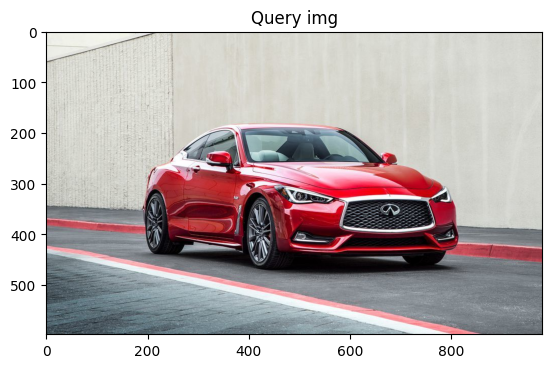

 - Nhãn: 1


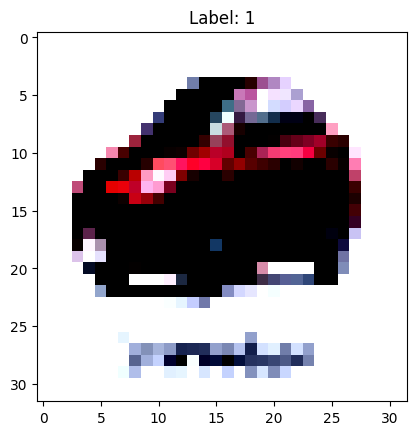

 - Nhãn: 1


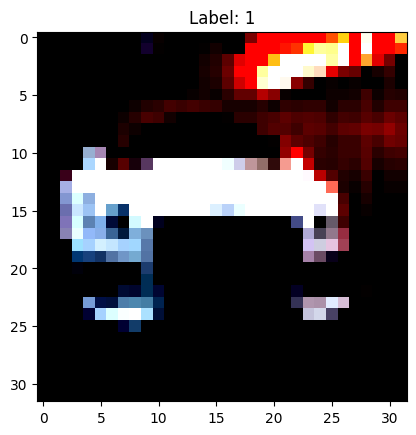

 - Nhãn: 1


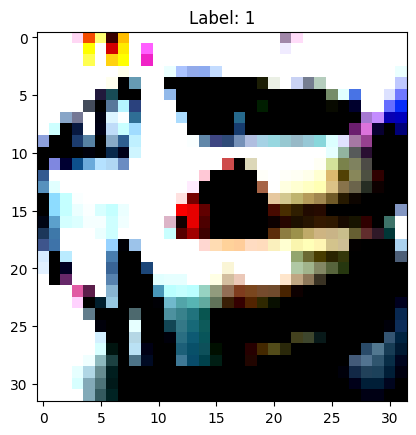

 - Nhãn: 9


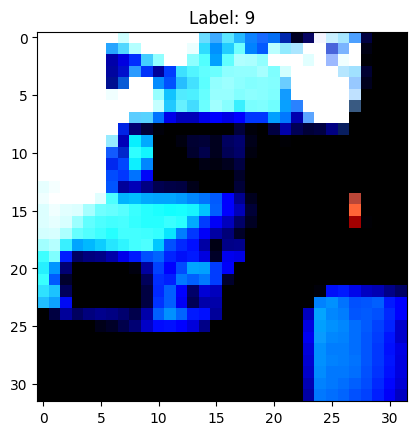

 - Nhãn: 1


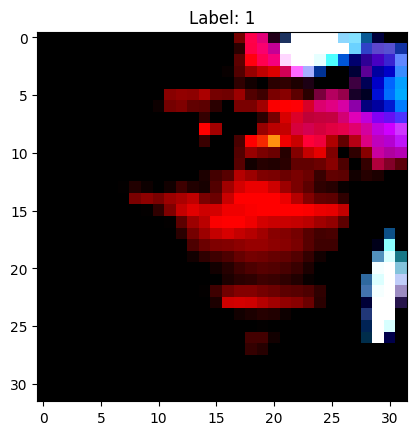

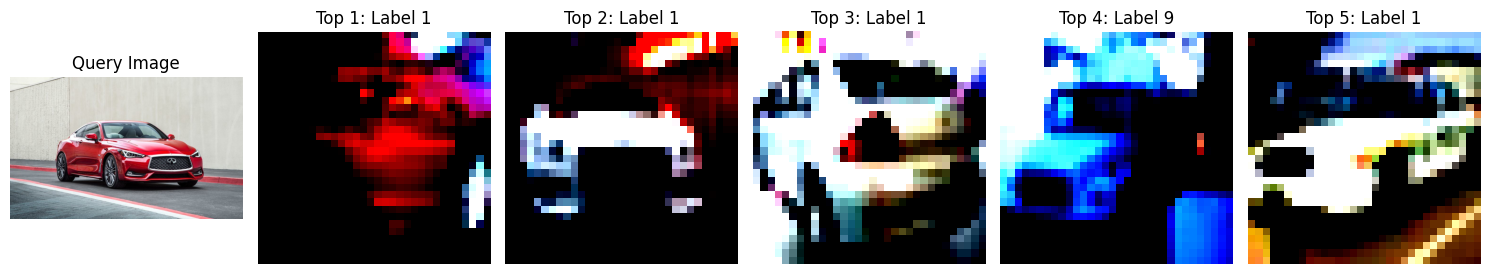

In [ ]:
######################################## VIẾT HÀM MAIN_2 ĐỂ DÙNG MÔ HÌNH ĐÃ HUẤN LUYỆN TRUY VẤN ẢNH ##########################

def main_2():
    from pathlib import Path
    from torchvision import transforms
    from torchvision.datasets import CIFAR10
    import matplotlib.pyplot as plt

    # 1. Khởi tạo args để tạo model
    class Args:
        hash_length = 48
        learning_rate = 0.0001
        weight_decay = 0.004
        regularization_weight_alpha = 0.01

    args = Args()
    ckpt_path = '/content/drive/MyDrive/Docs/Result/sota_dsh_baseline_cifar10/version_0/checkpoints/last.ckpt'  # 👉 chỉnh lại đường dẫn đến file .ckpt
    model = load_model_from_ckpt(ckpt_path, args)

    # 2. Load hash codes đã lưu từ file
    hash_data_path = Path('/content/drive/MyDrive/Docs/Result/sota_dsh_baseline_cifar10/hash_codes.pt')  # 👉 thay bằng file bạn đã lưu
    if not hash_data_path.exists():
        print("❌ hash_train_data.pt chưa được tạo. Hãy chạy huấn luyện trước hoặc tạo file này.")
        return
    data = torch.load(hash_data_path)
    train_hash_codes = data['train_hash_codes']
    train_images = data['train_images']
    train_ground_truths = data['train_labels']

    # 3. Load lại dataset ảnh gốc
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    train_dataset = CIFAR10(root='/content/drive/MyDrive/Docs/CIFAR-10/cifar-10', train=True, download=True, transform=transform_test)

    # 4. Truy vấn ảnh bất kỳ
    query_img_path = '/content/drive/MyDrive/Docs/Checkpoint/R.jpg'  # 👉 chỉnh lại đường dẫn ảnh truy vấn
    query_image(query_img_path, model, train_hash_codes, train_ground_truths,train_images)
    faiss_hnsw_search(query_img_path, model, train_hash_codes, train_images, train_ground_truths, k=5)
if __name__ == '__main__':
    # Gọi hàm main_2 để thực hiện truy vấn
    main_2()
    # Gọi hàm main để huấn luyện lấy trọng số
    '''
    main(
    batch_size=100,
    dataset_dir=Path('/content/drive/MyDrive/Docs/CIFAR-10/cifar-10'),
    logs_dir=Path('/content/drive/MyDrive/Docs/Result'),
    experiment_name='sota_dsh_baseline_cifar10',
    num_workers=2,
    finetune=True,
    finetune_ckpt='/content/drive/MyDrive/Docs/Result/sota_dsh_baseline_cifar10/version_0/checkpoints/last.ckpt'
    )
   '''